# Modelling a Chemical Reactor Using Machine Learning, Part 1: Predicting Product Yield

Richard Kaldenhoven

Updated June 14, 2021. Original Version May 3, 2021

## 1. Introduction

Many products from industrial chemical processes are manufactured in a chemical reactor, the type of equipment used to carry out chemical reactions at a large scale. Feed chemicals are sent to the reactor and then the products are withdrawn, either in a batch or continuous process. If the reaction is endothermic (absorbs heat) or exothermic (releases heat), then energy must be added or removed from the reactor to control the reaction temperature. The chemical reaction that produces the desired product may be joined by side reactions that produce undesired products.

The design of an efficient chemical reactor must take into consideration the feed conditions, energy requirements, side reactions, as well as the desired product quality. The economics of the process may depend on the ability to create a product of a certain quality, for example, an inefficient reactor may require additional equipment to separate out the desired product from the undesired products. A useful performance metric to measure the amount of desired product is the **overall yield (Y)**, defined generally as:

$ Y = \frac{amount \space of \space desired \space product \space produced}{amount \space of \space feed \space component \space reacted} $


In other words, the overall yield is a fraction (values from 0 to 1) representing how much product is created for the amount of feed that is sent to the reactor. Once a chemical reactor is in operation, the yield must still be maximized by adapting to changes in process conditions in order to maintain the desired product quality. 

The purpose of this project is to demonstrate how machine learning can be used to model the relationship between the process conditions and the overall yield, so that a real time prediction for reactor performance can be provided to those involved with operating the reactor. A real time prediction for reactor performance given by a machine learning model can be part of a system that raises a warning if the yield decreases below a target value, and then provides information on which process conditions are causing the decrease so that action can be taken to return to maximum yield.

## 2. Data Generation

In order to define the machine learning problem it is first necessary to explain the source of the data that will be used. Since operating data for a real world reactor is not available, data will be generated based on an analytical model of an example reactor. The analytical model will require values for the input variables to the reactor, such as the chemical reaction parameters, and then return values for the output variables, such as the overall yield. 

The reactor will operate in two modes:

1. **Mode 1 - Baseline Operation Case:** Normal operation, with relatively high yield
2. **Mode 2 - Off Spec Case:** Abnormal operation, with relatively low yield

The following gas phase chemical reactions are considered:

$ (1) \space \space A + 2B \rightarrow C $

$ (2) \space \space 2A + 3C \rightarrow 3D $

The reactions are considered to be complex, since it is a combination of series and parallel side reactions: reactant A and product C react to form D. Since the reaction order and activation energy are higher for the second reaction, in order to maximize yield, the feed to the reactor must have a low concentration of A and a low temperature. It will be shown that the difference in operating modes comes results from differences in these feed parameters.

The reactions are carried out in a Plug Flow Reactor (PFR), a type of reactor that resembles a pipe, with the reaction progressing down the length of the pipe. The reactions are exothermic, so cooling water is fed in a jacket surrounding the reactor in a co-current configuration, as shown in the following schematic.

<img src='reactor.jpg' width='800' height='600' />

The example reactor used in this project is based on Example 12-7 in *Essentials of Chemical Reaction Engineering* [1], with several reaction parameters changed to make the side reaction (2) and heat generated from the reactions more significant relative to the feed conditions.

The strategy used to generate data takes the following steps:

1. Establish a baseline operation case from an analytical model of a reactor by solving the equations describing the process
2. To simulate real world operation, apply variation to the input values to the analytical model for each operating mode, and track the effect on the output values such as the overall yield
3. Generate "noise" data in the range between operating modes, to make their boundaries less distinct

If the reader is purely interested in the machine learning aspects of this project, they may skip to Section 2.3 where the generated data is presented.

### 2.1 Baseline Operation Case

The equations for the analytical reactor model are as follows:

**Complex Gas Phase Reactions, with elementary rate laws**

$ (1) \space \space A + 2B \rightarrow C $

$ (2) \space \space 2A + 3C \rightarrow 3D $

$ -r_{1A} = k_{1A}C_{A}C_{B}^2 $

$ -r_{2C} = k_{2C}C_{A}^2C_{C}^3 $

**Reaction Parameters**

$ \Delta H_{Rx1B} = -10000 \space cal/mol B $

$ \Delta H_{Rx2A} = -8000  \space cal/mol A $

$ k_{1A} = 40 \space (dm^3/mol)^2/min = 40[\frac{E_{1}}{R}(\frac{1}{T_{o}} - \frac{1}{T})] \space (dm^3/mol)^2/min $ (using Arrhenius equation to express as a function of temperature)

$ k_{2c} = 40 \space (dm^3/mol)^2/min = 40[\frac{E_{1}}{R}(\frac{1}{T_{o}} - \frac{1}{T})] \space (dm^3/mol)^2/min $ (using Arrhenius equation to express as a function of temperature)

$ E_{1} = 8000 \space cal/mol $

$ E_{2} = 14000 \space cal/mol $

**Mole and Energy Balance Parameters**

$ F_{A} = 5 \space mol/min $

$ F_{B} = 10 \space mol/min $ (stoichiometric ratio with A)

$ V = 20 \space m^3 $

$ T_{o} = 300 \space K $

$ C_{To} = 0.2 \space mol/dm^3 $

$ P = 4.92 \space atm $ (constant pressure in reactor, no pressure drop)

$ y = 1 $ (no pressure drop)

$ m = 10 \space mol/min $

$ C_{PCo} = 18.02 \space cal/mol K $

$ T_{A} = 325 \space K $

$ C_{PA} = 10 \space cal/mol K $

$ C_{PB} = 12 \space cal/mol K $

$ C_{PC} = 14 \space cal/mol K $

$ C_{PD} = 16 \space cal/mol K $

$ Ua = 80 \space cal/min K $

**Mole Balances**

$ \frac{dF_{A}}{dV} = r_{A} $

$ \frac{dF_{B}}{dV} = r_{B} $

$ \frac{dF_{C}}{dV} = r_{C} $

$ \frac{dF_{D}}{dV} = r_{D} $

**Reaction Rates**

Rate Laws

$ -r_{1A} = k_{1A}C_{A}C_{B}^2 $

$ -r_{2C} = k_{2C}C_{A}^2C_{C}^3 $

Relative Rates

$ r_{1B} = 2r_{1A} $

$ r_{1C} = -r_{1A} $

$ r_{2A} = \frac{2}{3}r_{2C} $

$ r_{2D} = \frac{-3}{3}r_{2C} $

Net Rates

$ r_{A} = r_{1A} + r_{2A} $

$ r_{B} = r_{1B} $

$ r_{C} = r_{1C} + r_{2C} $

$ r_{D} = r_{2D} $

**Stoichiometry**

$ C_{A} = C_{To}(\frac{F_{A}}{F_{T}})(\frac{T_{o}}{T})y $

$ C_{B} = C_{To}(\frac{F_{B}}{F_{T}})(\frac{T_{o}}{T})y $

$ C_{C} = C_{To}(\frac{F_{C}}{F_{T}})(\frac{T_{o}}{T})y $

$ C_{D} = C_{To}(\frac{F_{D}}{F_{T}})(\frac{T_{o}}{T})y $

$ F_{T} = F_{A} + F_{B} + F_{C} + F_{D} $


**Energy Balance**

$ \frac{dT}{dV} = \frac{Q_{g} - Q_{r}}{\sum F_{j}C_{Pj}} $

$ \sum F_{j}C_{Pj} = F_{A}C_{PA} + F_{B}C_{PB} + F_{C}C_{PC} + F_{D}C_{PD} $

Heat Removed

$ Q_{r} = Ua(T - T_{a}) $

Heat Generated

$ Q_{g} = \sum r_{ij} \Delta H_{Rij} = r_{1B}\Delta H_{Rx1B} + r_{2A}\Delta H_{Rx2A}$

Co-current Heat Exchange

$ \frac{dTa}{dV} = \frac{Ua(T - T_{a})}{mC_{PCo}} $

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The system of equations defined previously will be solved using the `solve_ivp` function from the Scipy library (the equations are a system of differential equations). To begin, the parameters are stored in a dictionary:

In [2]:
params = {'V': 20,
         'E2': 14000,
         'k2c_const': 40,
         'y': 1,
         'R': 1.987,
         'To': 300,
         'E1': 8000,
         'Cto': 0.2,
         'Cpco': 18.02,
         'm': 10,
         'k1a_const': 40,
         'DH1b': -10000,
         'DH2a': -8000,
         'Cpd': 16,
         'Cpa': 10,
         'Cpb': 12,
         'Cpc': 14,
         'Ua': 80}

A function `odes` is then created which contains all of the previously defined equations:

In [3]:
def odes(V, x):
    try:
        # assign variables that vary with respect to V as values from list x
        Fa = x[0]
        Fb = x[1]
        Fc = x[2]
        Fd = x[3]
        T = x[4]
        Ta = x[5]        
        # explicit equations and constants
        E2 = params['E2']
        y = params['y']
        R = params['R']
        Ft = Fa + Fb + Fc + Fd
        To = params['To']
        k2c = params['k2c_const'] * math.exp((E2/R)*(1/300 - 1/T))
        E1 = params['E1']
        Cto = params['Cto']
        Ca = Cto * (Fa/Ft) * (To/T) * y    
        Cc = Cto * (Fc/Ft) * (To/T) * y
        r2c = -k2c * Ca**2 * Cc**3
        Cpco = params['Cpco']
        m = params['m']
        Cb = Cto * (Fb/Ft) * (To/T) * y
        k1a = params['k1a_const'] * math.exp((E1/R)*(1/300 - 1/T))
        r1a = -k1a * Ca * Cb**2
        r1b = 2 * r1a
        rb = r1b
        r2a = 2/3 * r2c
        DH1b = params['DH1b']
        DH2a = params['DH2a']
        r1c = -r1a
        Cpd = params['Cpd']
        Cpa = params['Cpa']
        Cpb = params['Cpb']
        Cpc = params['Cpc']
        sumFiCpi = Cpa * Fa + Cpb * Fb + Cpc * Fc + Cpd * Fd
        rc = r1c + r2c
        Ua = params['Ua']
        r2d = -3/3 * r2c # -1/3 changed to -3/3
        ra = r1a + r2a
        rd = r2d
        Qg = r1b * DH1b + r2a * DH2a
        Qr = Ua * (T - Ta)    
        # define each ODE
        dFa_dV = ra
        dFb_dV = rb
        dFc_dV = rc
        dFd_dV = rd
        dT_dV = (Qg - Qr) / sumFiCpi
        dTa_dV = Ua * (T - Ta) / (m * Cpco)
        return [dFa_dV, dFb_dV, dFc_dV, dFd_dV, dT_dV, dTa_dV]
    except:
        pass

Initial conditions for the equations are defined:

In [4]:
#     initial conditions, co-current heat exchange
#    [Fa, Fb, Fc, Fd, T, Ta]
xo = [5, 10, 0, 0, 300, 325]

Next, the `t_eval` variable stores the volumes at which `solve_ivp` will record results. The `solve_ivp` function assumes that time is always the dependendent variable, however in this problem it is the volume, but "time" is still referred to in order to be consistent with how the function works.

In [5]:
t_eval = np.linspace(0, params['V'], params['V'] + 1)

`solve_ivp` is called, and the results are stored in the variable `solution`. `solution.t` shows the volumes at which the analytical model results are calculated at. `solution.y` is an array of results for each differential equation, at each volume value in `solution.t`.

In [6]:
solution = solve_ivp(odes, [0, params['V']], xo, t_eval = t_eval)

In [7]:
solution.t

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

In [8]:
solution.y

array([[5.00000000e+00, 4.93920184e+00, 4.85343179e+00, 4.74223346e+00,
        4.59985894e+00, 4.41289230e+00, 4.15235791e+00, 3.75220968e+00,
        3.03844644e+00, 1.79278790e+00, 8.22316779e-01, 4.53067034e-01,
        2.99167747e-01, 2.17668610e-01, 1.64828934e-01, 1.28756206e-01,
        1.02735203e-01, 8.33453430e-02, 6.85029962e-02, 5.69645322e-02,
        4.77245593e-02],
       [1.00000000e+01, 9.87840368e+00, 9.70686358e+00, 9.48446695e+00,
        9.19971813e+00, 8.82578592e+00, 8.30472502e+00, 7.50449788e+00,
        6.07820792e+00, 3.63269304e+00, 1.96741790e+00, 1.42847956e+00,
        1.21013555e+00, 1.09190168e+00, 1.01379575e+00, 9.59123553e-01,
        9.18705725e-01, 8.87832941e-01, 8.63643435e-01, 8.44409148e-01,
        8.28711481e-01],
       [0.00000000e+00, 6.07981580e-02, 1.46568207e-01, 2.57766501e-01,
        4.00140742e-01, 5.87106058e-01, 8.47630592e-01, 1.24769217e+00,
        1.95990977e+00, 3.14831555e+00, 3.77420279e+00, 3.89400110e+00,
        3.9360

In order to understand the results of the analytical model, the values are plotted using the following code.

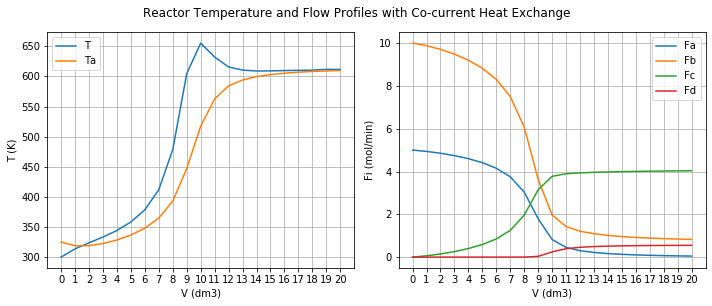

In [9]:
T = solution.y[4]
Ta = solution.y[5]

Fa = solution.y[0]
Fb = solution.y[1]
Fc = solution.y[2]
Fd = solution.y[3]

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(10,4))
fig.suptitle('Reactor Temperature and Flow Profiles with Co-current Heat Exchange', y = 1.05)

ax1.plot(T)
ax1.plot(Ta)
ax1.legend(['T', 'Ta'])
ax1.set_xticks(t_eval)
ax1.set(xlabel='V (dm3)', ylabel='T (K)')
ax1.grid()

ax2.plot(Fa)
ax2.plot(Fb)
ax2.plot(Fc)
ax2.plot(Fd)
ax2.legend(['Fa', 'Fb', 'Fc', 'Fd'])
ax2.set(xlabel='V (dm3)', ylabel='Fi (mol/min)')
ax2.grid()

plt.tight_layout()

The x-axis of the plots can be interpreted as the reactor "length": each increment in volume represents moving along the length of the reactor. The temperature plot shows how the temperature rises as the reaction proceeds within the reactor, and how the cooling water temperature rises to limit the reaction temperature. The Flow Profiles show how reactants A and B decrease in flow rate as they are converted to products C and D. Product C is the dominant chemical in the products, however undesired product D is also present along with some of A that has not reacted.

It is possible to calculate the outlet temperature, maximum reactor temperature, outlet concentration of C, the conversion of A (amount of A reacted/amount of A in feed), and the overall yield based on values stored in `solution`, as shown in the following code. 

The **overall conversion of A (`Xa`)** is calculated using the following formula:

$ X_{a} = \frac{F_{Ao} - F_{Aout}}{F_{Ao}} $

The **yield of product C (`Yc`)** is calculated as:

$ Y_{c} = \frac{F_{Cout}}{F_{Ao} - F_{Aout}} $

In [10]:
Fao = solution.y[0][0]
Fbo = solution.y[1][0]
Fa_out = solution.y[0][-1]
Fb_out = solution.y[1][-1]
Fc_out = solution.y[2][-1]
Fd_out = solution.y[3][-1]
F_out = Fa_out + Fb_out + Fc_out + Fd_out

print('Feed Flowrates A, B (mol/min): ', round(Fao, 3), round(Fbo, 3))
print('Outlet Flowrates A, B, C, D (mol/min): ', round(Fa_out, 3), round(Fb_out, 3), round(Fc_out, 3), round(Fd_out, 3),)

To = xo[4]
T_out = solution.y[4][-1]

T_max = max(solution.y[4])
print('Maximum Reactor Temperature (K): ', round(T_max, 3))

Cc_out = params['Cto'] * (Fc_out / F_out) * (To / T_out)
print('Outlet concentration of C (mol/dm3): ', round(Cc_out, 3))

Xa = (Fao - Fa_out) / Fao
print('Overall Conversion of A: ', round(Xa, 3))

#S_cd = Fc_out / Fd_out
#print('Overall Selectivity of C vs. D: ', round(S_cd, 3))

Yc = Fc_out / (Fao - Fa_out)
print('Overall Yield of C: ', round(Yc, 3))

Feed Flowrates A, B (mol/min):  5.0 10.0
Outlet Flowrates A, B, C, D (mol/min):  0.048 0.829 4.036 0.55
Maximum Reactor Temperature (K):  655.251
Outlet concentration of C (mol/dm3):  0.072
Overall Conversion of A:  0.99
Overall Yield of C:  0.815


### 2.2 Applying Variation

With a baseline operation case, it is possible to vary the inputs to the analytical model and track the effect on the outputs. The inputs are varied by drawing a random number from a normal distribution, using the `gen_rand_num` function, which takes the mean and standard deviation as arguments.

In [11]:
def gen_rand_num(mean, std):
    return float(np.random.normal(mean, std, 1))

To apply variation to the inputs, it is also necessary to define what the mean and standard deviation of the distribution of randomly drawn numbers are for each operating mode, which is achieved by using two dictionaries: `base_dict` and `lim_dict`.

`base_dict` stores the inputs from the base operation case, and these values will become the mean of the distribution of randomly drawn numbers.

`lim_dict` stores values representing the fractions of each input that correspond to one standard deviation of the distribution of randomly drawn numbers. For example, one standard deviation of the flowrate `Fa` is equal to 5 x 0.1 = 0.5. The fractions are chosen to be small to simulate operation that does not vary to much from the baseline (a narrow distribution having a small standard deviation). 
   
        

In [12]:
# Mode 1
base_dict_1 = {'Fa': 5, 'Fb': 10, 'P': 4.92, 'To': 300, 'm': 10, 'Ta': 325}
lim_dict_1 = {'Fa': 0.1, 'Fb': 0.1, 'P': 0.1, 'To': 0.03, 'm': 0.2, 'Ta': 0.03}

# Mode 2
base_dict_2 = {'Fa': 3, 'Fb': 4, 'P': 10, 'To': 500, 'm': 5, 'Ta': 325}
lim_dict_2 = {'Fa': 0.05, 'Fb': 0.05, 'P': 0.05, 'To': 0.015, 'm': 0.1, 'Ta': 0.015}

The function `generate_data` will loop `num_samples` times, randomly selecting input values using `gen_rand_num` based on the values contained in `base_dict` and `lim_dict`. The `params` dictionary and initial conditions `xo` are then updated and the analytical model equations are solved using `solve_ivp`, as before. Input values and output values are returned in an array.

In [13]:
def generate_data(num_samples, base_dict, lim_dict, random_seed=0):    
    sample_list = []    
    np.random.seed(random_seed)
    for i in range(0, num_samples):        
        # Flowrates
        Fao = gen_rand_num(base_dict['Fa'], base_dict['Fa'] * lim_dict['Fa'])
        Fbo = gen_rand_num(base_dict['Fb'], base_dict['Fb'] * lim_dict['Fb'])
        # Pressure
        P = gen_rand_num(base_dict['P'], base_dict['P'] * lim_dict['P'])
        # Inlet Temperature
        To = gen_rand_num(base_dict['To'], base_dict['To'] * lim_dict['To'])
        # Inlet Total Concentration
        Cto = P / (0.082 * To)
        # Cooling medium flowrate
        m = gen_rand_num(base_dict['m'], base_dict['m'] * lim_dict['m'])
        # Inlet cooling medium temperature
        Ta = gen_rand_num(base_dict['Ta'], base_dict['Ta'] * lim_dict['Ta'])
        # update params dictionary
        params['To'] = To
        params['Cto'] = Cto
        params['m'] = m
        # update ODE initial conditions
        #     initial conditions, co-current heat exchange
        #    [Fa, Fb, Fc, Fd, T, Ta]
        xo = [Fao, Fbo, 0, 0, To, Ta]
        # Solve ODEs
        solution = solve_ivp(odes, [0, params['V']], xo, t_eval = t_eval)
        # Calculate outlet values
        Fao = solution.y[0][0]
        Fa_out = solution.y[0][-1]
        Fb_out = solution.y[1][-1]
        Fc_out = solution.y[2][-1]
        Fd_out = solution.y[3][-1]
        F_out = Fa_out + Fb_out + Fc_out + Fd_out
        To = xo[4]
        T_out = solution.y[4][-1]        
        T_max = max(solution.y[4])
        Cc_out = params['Cto'] * (Fc_out / F_out) * (To / T_out)
        Xa = (Fao - Fa_out) / Fao
        #S_cd = Fc_out / Fd_out
        Yc = Fc_out / (Fao - Fa_out)        
        sample_list.append([Fao, Fbo, P, To, Cto, m, Ta, T_max, Fa_out, Fb_out, Fc_out, Fd_out, Cc_out, Xa, Yc])        
    data = np.asarray(sample_list)    
    return data

Noise data is generated by first selecting values from a uniform distribution with a range equal to the values between operating Mode 1 and 2, using the function `noise_value`.

In [14]:
# Noise
def noise_value(key):
    high = max([base_dict_1[key], base_dict_2[key]])
    low = min([base_dict_1[key], base_dict_2[key]])    
    return float(np.random.uniform(low, high, 1))

Noise data is then generated using `generate_noise_data` which works in the same manner as `generate_data`, however instead of selecting random values from a normal distribution, the function `noise_value` is used to select values for the input process variables.

In [15]:
def generate_noise_data(num_samples, base_dict_1, base_dict_2, lim_dict, random_seed=0):    
    sample_list = []    
    np.random.seed(random_seed)
    for i in range(0, num_samples):        
        # Flowrates
        Fao = noise_value(key='Fa')
        Fbo = noise_value(key='Fb')
        # Pressure
        P = noise_value(key='P')
        # Inlet Temperature
        To = noise_value(key='To')
        # Inlet Total Concentration
        Cto = P / (0.082 * To)
        # Cooling medium flowrate
        m = noise_value(key='m')        
        # Inlet cooling medium temperature
        Ta = gen_rand_num(base_dict_1['Ta'], base_dict_1['Ta'] * lim_dict['Ta'])
        # update params dictionary
        params['To'] = To
        params['Cto'] = Cto
        params['m'] = m
        # update ODE initial conditions
        #     initial conditions, co-current heat exchange
        #    [Fa, Fb, Fc, Fd, T, Ta]
        xo = [Fao, Fbo, 0, 0, To, Ta]
        # Solve ODEs
        solution = solve_ivp(odes, [0, params['V']], xo, t_eval = t_eval)
        # Calculate outlet values
        Fao = solution.y[0][0]
        Fa_out = solution.y[0][-1]
        Fb_out = solution.y[1][-1]
        Fc_out = solution.y[2][-1]
        Fd_out = solution.y[3][-1]
        F_out = Fa_out + Fb_out + Fc_out + Fd_out
        To = xo[4]
        T_out = solution.y[4][-1]        
        T_max = max(solution.y[4])
        Cc_out = params['Cto'] * (Fc_out / F_out) * (To / T_out)
        Xa = (Fao - Fa_out) / Fao
        #S_cd = Fc_out / Fd_out
        Yc = Fc_out / (Fao - Fa_out)        
        sample_list.append([Fao, Fbo, P, To, Cto, m, Ta, T_max, Fa_out, Fb_out, Fc_out, Fd_out, Cc_out, Xa, Yc])        
    data = np.asarray(sample_list)    
    return data

It is now possible to create a dataset for machine learning. 1500 samples are generated by calling `generate_data` for Mode 1 and Mode 2, then `generate_noise_data` to create noisy data between operating modes. The data is converted from a Numpy array into a Pandas DataFrame, and then saved to a CSV file so that results may be reproduced later, if necessary.

In [16]:
num_samples_1 = 900
num_samples_2 = 450
num_samples_3 = 150

data_1 = generate_data(num_samples_1, base_dict_1, lim_dict_1, random_seed=0)
data_2 = generate_data(num_samples_2, base_dict_2, lim_dict_2, random_seed=0)
data_3 = generate_noise_data(num_samples_3, base_dict_1, base_dict_2, lim_dict_1, random_seed=0)

In [17]:
columns = ['Fao', 'Fbo', 'P', 'To', 'Cto', 'm', 'Ta', 'T_max', 'Fa_out', 'Fb_out', 'Fc_out', 'Fd_out', 'Cc_out', 'Xa', 'Yc']

df_1 = pd.DataFrame(data=data_1, columns = columns)
df_2 = pd.DataFrame(data=data_2, columns = columns)
df_3 = pd.DataFrame(data=data_3, columns = columns)

df = df_1.append(df_2)
df = df.append(df_3)
print(df.shape)

(1500, 15)


In [18]:
# save dataframe to csv file so that results can be reproduced later
df.to_csv('reactor_model_v5.csv')

### 2.3 Exploring the Data

A preview of the dataset is given below. The columns from `Fao` to `Ta` represent input values to the reactor model, and columns `T_max` to `Yc` are the output values.

In [19]:
df.head()

,Fao,Fbo,P,To,Cto,m,Ta,T_max,Fa_out,Fb_out,Fc_out,Fd_out,Cc_out,Xa,Yc
0,5.882026,10.400157,5.401539,320.168039,0.205743,13.735116,315.471541,677.484905,0.086902,0.522703,3.654131,1.284596,0.075450,0.985226,0.630553
1,5.475044,9.848643,4.869216,303.695387,0.195527,10.288087,339.179167,667.541928,0.094176,0.523220,3.585476,1.077235,0.064267,0.982799,0.666338
2,5.380519,10.121675,5.138381,303.003069,0.206807,12.988158,322.999707,649.174802,0.090616,0.656290,3.896878,0.835815,0.077688,0.983158,0.736663
3,5.156534,9.145904,3.663929,305.882567,0.146076,11.728872,317.763891,404.957770,3.744916,6.322772,1.411489,0.000078,0.013567,0.273753,0.999908
4,6.134877,8.545634,4.942513,298.315345,0.202050,13.065558,339.326248,611.421496,0.606274,0.221884,2.111783,2.050092,0.043985,0.901176,0.381974


Using the `describe` Pandas function, it is possible to check the values that have been generated from the previous section.

In [20]:
df.describe().transpose().apply(lambda s: s.apply('{0:.3f}'.format))

,count,mean,std,min,25%,50%,75%,max
Fao,1500.000,4.284,0.986,2.551,3.131,4.541,5.077,6.340
Fbo,1500.000,7.877,2.861,3.391,4.185,9.113,10.181,12.980
P,1500.000,6.659,2.372,3.080,4.816,5.323,9.544,11.465
To,1500.000,370.042,92.274,276.462,298.439,308.415,493.808,519.052
Cto,1500.000,0.215,0.032,0.122,0.193,0.213,0.239,0.377
m,1500.000,8.280,2.786,3.670,5.386,8.465,10.427,17.603
Ta,1500.000,324.754,8.385,295.677,319.748,324.438,329.958,350.687
T_max,1500.000,661.452,62.543,338.814,631.025,659.177,685.330,932.613
Fa_out,1500.000,0.170,0.471,0.000,0.001,0.021,0.122,5.225
Fb_out,1500.000,0.883,1.086,0.002,0.082,0.607,1.260,9.690


The mean values for each operating mode are shown in the following table. As expected, the input values have a mean close to the value set previously in `base_dict_1` and `base_dict_2`.

In [21]:
df_1_mean = df_1.describe().loc['mean'].values
df_2_mean = df_2.describe().loc['mean'].values
means = np.array([df_1_mean, df_2_mean])

df_means = pd.DataFrame(data=means, columns=df.columns.values).apply(lambda s: s.apply('{0:.3f}'.format))
df_means['Mode'] = pd.Series([1, 2])
df_means = df_means[['Mode', 'Fao', 'Fbo', 'P', 'To', 'Cto', 'm', 'Ta', 'T_max', 'Fa_out', 'Fb_out', 'Fc_out', 'Fd_out', 'Cc_out', 'Xa', 'Yc']]
df_means.set_index('Mode', inplace=True)
df_means

,Fao,Fbo,P,To,Cto,m,Ta,T_max,Fa_out,Fb_out,Fc_out,Fd_out,Cc_out,Xa,Yc
Mode,,,,,,,,,,,,,,,
1,4.972,9.965,4.893,300.373,0.199,10.055,324.789,643.695,0.247,1.303,3.740,0.591,0.065,0.952,0.804
2,2.993,3.984,9.963,500.483,0.243,5.016,324.899,661.397,0.024,0.062,0.449,1.512,0.042,0.992,0.153


As a quick check of how the input values are distributed, histograms for each column in `df` are plotted, showing a normal distribution for each.

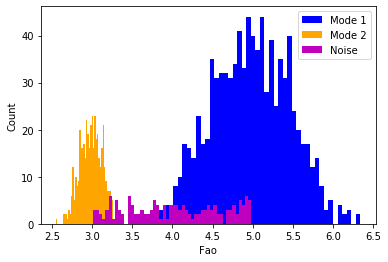

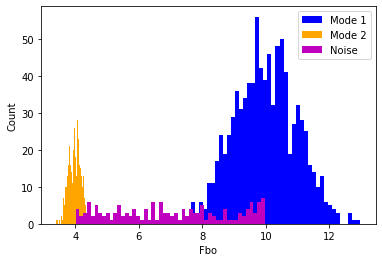

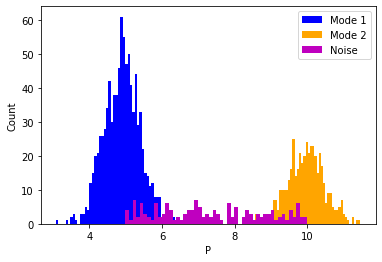

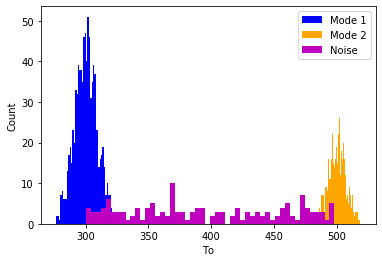

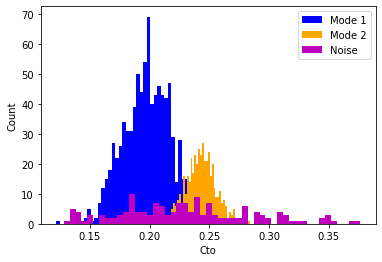

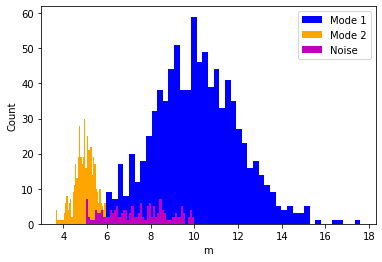

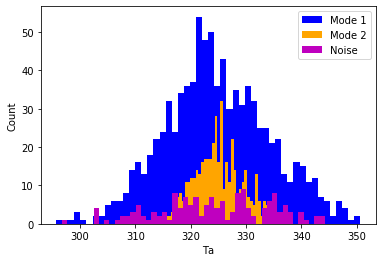

In [22]:
input_value_cols = ['Fao', 'Fbo', 'P', 'To', 'Cto', 'm', 'Ta']
for i, col in enumerate(df[input_value_cols]):
    plt.figure(i)
    plt.hist(df_1[col], bins=50, color='b', label='Mode 1')
    plt.hist(df_2[col], bins=50, color='orange', label='Mode 2')
    plt.hist(df_3[col], bins=50, color='m', label='Noise')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.legend()

Histograms of the output values are also plotted:

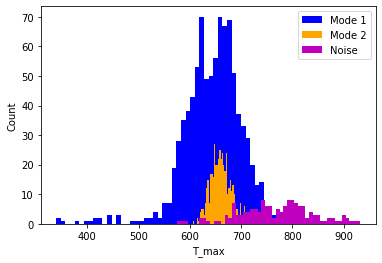

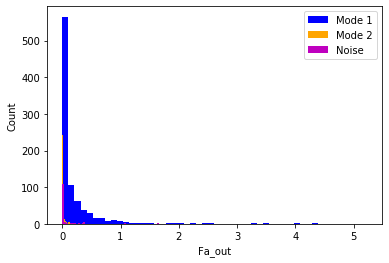

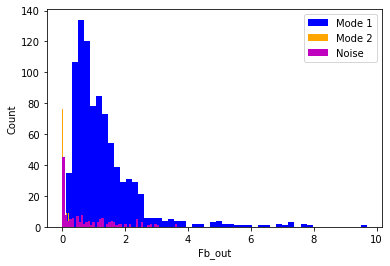

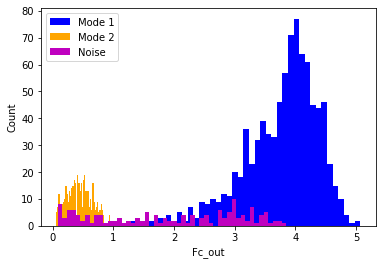

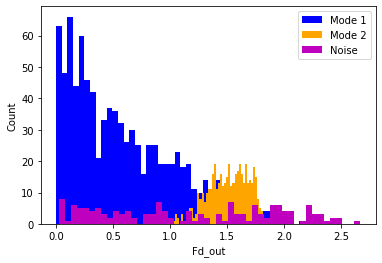

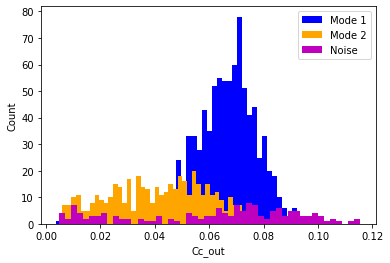

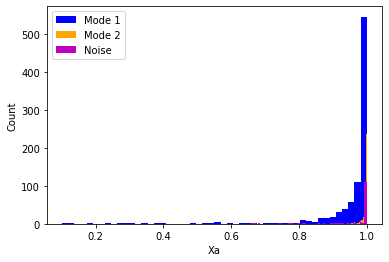

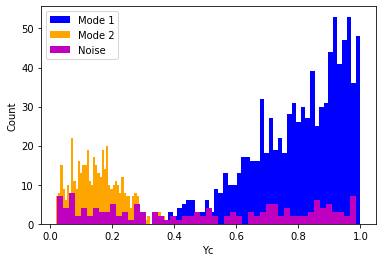

In [23]:
output_value_cols = ['T_max', 'Fa_out', 'Fb_out', 'Fc_out', 'Fd_out', 'Cc_out', 'Xa', 'Yc']
for i, col in enumerate(df[output_value_cols]):
    plt.figure(i)
    plt.hist(df_1[col], bins=50, color='b', label='Mode 1')
    plt.hist(df_2[col], bins=50, color='orange', label='Mode 2')
    plt.hist(df_3[col], bins=50, color='m', label='Noise')
    plt.ylabel('Count')
    plt.xlabel(col)
    plt.legend()

A heatmap showing the correlation coefficients between the values provides more insight into their relationships with `Yc`:

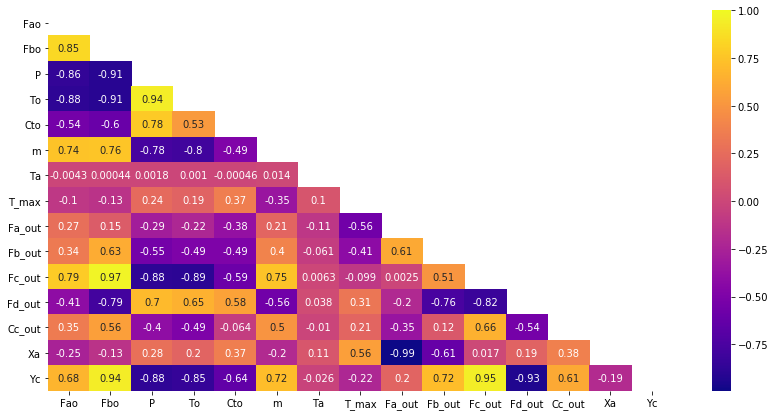

In [24]:
corr = df.corr()
mask = np.triu(corr)

plt.figure(figsize=(14,7))
sns.heatmap(df.corr(), annot = True, cmap='plasma', mask=mask, square=False)

The following observations made from the heatmap are consistent with what is expected from the reactor model, based on the theory behind chemical reactor engineering:

* As `Fao` increases, `Yc` increases. Normally the opposite is expected since from the definition of yield (see Section 2.1) as the amount of A in the feed increases, the yield of C decreases. However in this case there is a large difference between Mode 1 and 2, and higher values of `Fao` in Mode 1 correspond with higher values of `Yc`.

* As `Fbo` increases, `Yc` increases. This is consistent with the definition of instantaneous yield, given as: $ \tilde{Y}_{C} = \frac{k_{1A}}{k_{2C}}\frac{C_{B}^2}{C_{A}C_{C}^3} $ (see pg. 286 in [1] for an explanation of how to derive the instantaneous yield for a given set of reactions).

* As `P` increases, `Yc` decreases. As the pressure increases, the concentration of chemicals increases, as shown by the strong correlation between `P` and `Cto`. A high concentration of A lowers the yield. Mode 2 has a higher pressure than Mode 1, and so Mode 2 has a lower yield as a result.

* As `To` increases, `Yc` decreases. Since the activation energy of the undesired reaction (`E2`) is higher than for the desired reaction (`E1`) operating at too high a temperature as in Mode 2 will favor the undesired reaction, decreasing the yield.

* As `m` increases, `Yc` increases. Mode 1 has higher cooling water flow rates than Mode 2, so the reaction temeprature is lower resulting in an increased yield compared to Mode 2.

With a dataset available that appears to well represent the relationship between the input values to the reactor and the yield, the machine learning problem can now be defined in more detail.

## 3. Machine Learning Problem Definition

Predicting the overall yield of product C is a regression problem. The features provided for the machine learning model to learn patterns from during training will be the input values to the reactor model: `Fao`, `Fbo`, `P`, `To`, `Cto`, `m`, and `Ta`. The target variable to predict is `Yc`.

More features from the set of output values are not used, despite having relatively strong correlation coefficients, since the objective of this project is to show how the performance of a reactor can be predicted based purely on process conditions related to what is input to the reactor. If knowledge of the output values is also known, such as the flowrates, then it is possible to calculate the yield directly, without the need for a machine learning model. 

In a practical application, calculating the yield directly would require periodic sampling of the reactor products. The advantage of a machine learning approach would be that once enough sampling has been performed to establish a dataset suitable for a model to be trained on, the model could be used to make real time predictions for the product yield without having to take any samples.

## 4. Model Evaluation Protocol

Machine learning model performance will be evaluated based on a 60/40 train/test split of the data, using the Mean Absolute Error (MAE) metric, which is defined as:

$ MAE = \frac{\sum |predicted \space value - true \space value|}{number \space of \space samples} $

## 5. Data Preparation

The data is prepared for use in a machine learning model by saving the features to variable `X` and the target to `y`, then performing the train/test split.

In [25]:
X = df[input_value_cols]
y = df['Yc']

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## 6. Baseline Machine Learning Model

To start developing a machine learning model, a simple model is first created to set a baseline for performance. A Decision Tree model is created as its results are more interpretable than more sophisticated models. 

In [27]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(max_depth=4, criterion='mae', random_state=10)

tree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=10, splitter='best')

In [28]:
tree_pred = tree.predict(X_test)

The MAE for the Decision Tree model is calculated with the following code:

In [29]:
from sklearn.metrics import mean_absolute_error

tree_mae = mean_absolute_error(y_test, tree_pred)
print('MAE for Decision Tree: ', round(tree_mae, 3))

MAE for Decision Tree:  0.067


A visualization of the Decision Tree is provided in the following figure. Decision Trees predict values by learning a set of "decision paths" based on the patterns present in the dataset. In this case, the decisions are made in a way that reduces the MAE between the predicted value and the true value (in the training set) at each split, as shown in the figure. To interpret the tree, one considers a series of yes/no decisions (if yes move to the left, no to the right), following the tree downwards until the final level is reached. The final level represents the predicted value, or the output of the model.

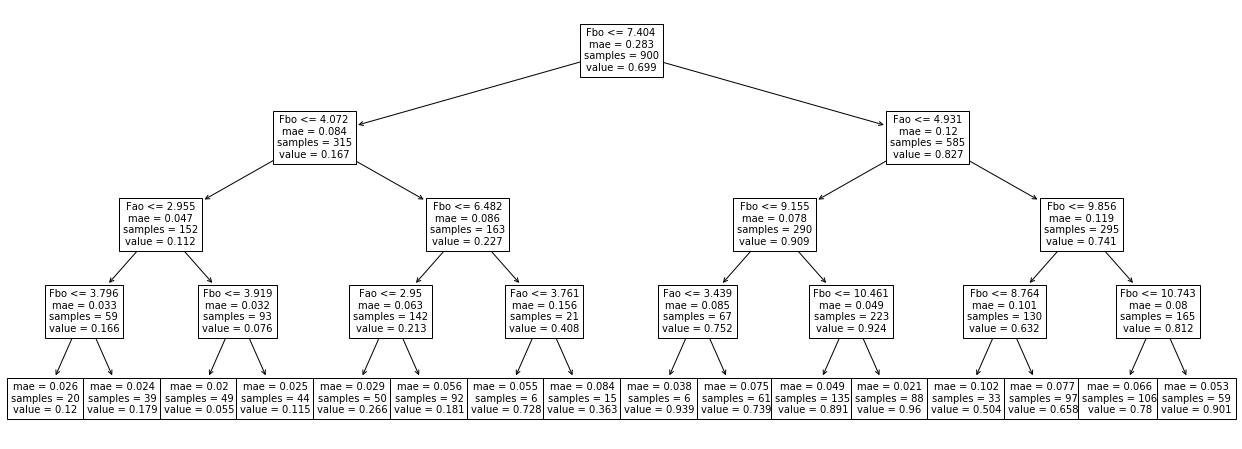

In [30]:
plt.figure(figsize=(22,8))
plot_tree(tree, fontsize=10, feature_names=input_value_cols);

The following table shows the importance of each feature in the Decision Tree. The feature importances are a representation of how significant each feature is in reducing the MAE each time a decision, or split, in the tree is made. In other words the feature importance is a measure of how much that feature factors into making a decision.

In [31]:
tree_dict = {'Feature':np.asarray(input_value_cols), 'Importance':tree.feature_importances_}

imp_df = pd.DataFrame(tree_dict, index=None)
imp_df.set_index('Feature', inplace=True)
imp_df.apply(lambda s: s.apply('{0:.3f}'.format))

,Importance
Feature,
Fao,0.095
Fbo,0.905
P,0.000
To,0.000
Cto,0.000
m,0.000
Ta,0.000


## 7. Improving Model Performance

To improve performance over the Decision Tree model, a Random Forest model is created. Random Forest models are developed by creating many decision trees, using a random sample of data from the training set for each tree. When a decision (or split) in a tree is made, a random subset of all available features is made, meaning that a split will not consider all of the available features. The predictions from all the trees are averaged to generate the final prediction. By creating two sources of randomness (the data used for training and the features used to determine the splits) errors from the individual trees cancel out and the overall variance in the model predictions is reduced, meaning that the model will have higher performance (a lower MAE) on the test dataset.

In [32]:
from sklearn.ensemble import RandomForestRegressor

rfm = RandomForestRegressor(random_state=10, criterion='mae')
rfm.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=10, verbose=0, warm_start=False)

In [33]:
rfm_pred = rfm.predict(X_test)

The MAE for the Random Forest model is calculated with the following code, and there is an absolute improvement of 0.038 or 61% over the Decision Tree model.

It is possible to perform cross validation and hyperparameter tuning to decrease the MAE of the Random Forest further, however since the data for this problem has been "faked" it is the authors opinion that these efforts would not provide much practical value. The MAE achieved for the dataset used here may represent a high level of model performance, however for real data it is possible that the MAE will be higher even with model performance maximized, making comparisons difficult.

In [34]:
rfm_mae = mean_absolute_error(y_test, rfm_pred)
print('MAE for Random Forest: ', round(rfm_mae, 3))

MAE for Random Forest:  0.029


The feature importances for the Random Forest model are shown in the following table, along with those from the Decision Tree model. The Random Forest uses all features to some extent, but `Fao`, `Fbo` and `P` remain the most important features to the model in predicting `Yc`.

In [35]:
rf_dict = {'Feature':np.asarray(input_value_cols), 'Decision Tree Importance':tree.feature_importances_, 'Random Forest Importance':rfm.feature_importances_}

rfimp_df = pd.DataFrame(rf_dict, index=None)
rfimp_df.set_index('Feature', inplace=True)
rfimp_df.apply(lambda s: s.apply('{0:.3f}'.format))

,Decision Tree Importance,Random Forest Importance
Feature,,
Fao,0.095,0.141
Fbo,0.905,0.775
P,0.000,0.030
To,0.000,0.013
Cto,0.000,0.016
m,0.000,0.013
Ta,0.000,0.012


## 8. Using the Machine Learning Model in Practice

Development of a machine learning model that can predict the overall yield of product C (`Yc`) based on the reactor input process conditions means that it is possible to create a system that can raise a warning when the yield drops below a target value during actual operation. Since Mode 1 is the desired mode of operation to maintain, the system will use the corresponding mean yield value as a target.

To demonstrate the concept of a low yield "warning system", data is gathered to serve as sample values that mimic what would be available from an actual operating reactor. The following code takes these steps:

1. Save the target yield value `base_Yc` (the mean value of the data generated for Mode 1 in Section 2.3) 
2. Save the corresponding mean input process conditions to `base_input_values` 
3. Take a subsample of the first five feature/target pairs `X_prac`/`y_prac` from the test dataset (created in Section 5). `X_prac` simulates the current input process conditions to the reactor, and `y_prac` represents the corresponding true yield values.

In [36]:
# Yield value from Mode 1
base_Yc = df_1.mean()['Yc']

base_input_values = df_1.mean()[input_value_cols].values

X_prac = X_test[:5]
y_prac = y_test[:5]

print('Baseline Yc: ', round(base_Yc, 3))
print('Sample Values of Yc:', y_prac.round(3).values)

Baseline Yc:  0.804
Sample Values of Yc: [0.159 0.95  0.825 0.558 0.783]


The MAE of the machine learning model developed in the previous section an be mitigated by setting a threshold value that must be exceeded before a warning is raised. For example, a yield value predicted by the machine learning model that is within the range of $ target \space value \pm threshold $ will not raise a warning. For simplicity, the threshold is set to be the MAE of the model, rounded up to two decimal places.

In [37]:
threshold = round(rfm_mae, 2)
print('Warning Threshold: ', threshold)

Warning Threshold:  0.03


The first and fourth sample values are outside of the threshold, so the machine learning model should predict that these values are below target and the system should raise a warning (The fifth value, 0.783, is greater than 0.804-0.03=0.774 so a warning is not raised).

The function `alert_low_yield` provides an example of how a low yield "warning system" could be created. The function takes the following arguments:
* `base_Yc`, the target yield 
* `base_input_values`, baseline values for the input process conditions corresponding to the desired mode of operation
* `input_value_cols`, a list of labels for the input process conditions 
* `data`, a single row of input process conditions that will be checked for low yield 
* `model`, a machine learning model that predicts the yield based on `data`
* `threshold`, the range of acceptable yield values
* `output`, an argument to show or hide output, defaults to True

`alert_low_yield` uses a machine learning model to make a prediction for the yield, based on `data`, and if the yield is less than `base_Yc`, provides a warning along with a comparison of the current reactor conditions and the baseline conditions, to show what is causing the low yield. The "Delta" values are calculated as the current values minus the baseline values, so that positive values indicate conditions above baseline, and negative below baseline.

In [38]:
def alert_low_yield(base_Yc, base_input_values, input_value_cols, data, model, threshold, output=True):
    
    predict_Yc = model.predict(data.reshape(1, -1))
    difference = abs(predict_Yc - base_Yc)
    
    alert = False
    
    if (predict_Yc < base_Yc) and (difference > threshold):
        
        alert = True
        delta = data - base_input_values
        results = {'Variable':input_value_cols, 
                   'Baseline Value':base_input_values, 
                   'Current Value': data, 
                   'Delta':delta}
        df_results = pd.DataFrame(results)
        df_results.set_index('Variable', inplace=True)

        if output:
            print('Warning: Yield below target!')
            print('Target Yc: ', round(base_Yc, 3))
            print('Current Yc: ', round(float(predict_Yc), 3))
        
            print('\nCurrent Reactor Input Conditions:')
            print(df_results.apply(lambda s: s.apply('{0:.3f}'.format)))

    else:
        if output:
            print('Yield greater than or equal to target.')
            print('Target Yc: ', round(base_Yc, 3))
            print('Current Yc: ', round(float(predict_Yc), 3))
            
    return alert

The following code executes `alert_low_yield` by stepping through each of the five rows in `X_prac`:

In [39]:
for i in range(0, len(X_prac)):
    print('----------------------------------------------')
    print('Step ', i+1)
    alert_low_yield(base_Yc, 
                    base_input_values,  
                    input_value_cols, 
                    data=X_prac.values[i], 
                    model=rfm, 
                    threshold=threshold, 
                    output=True)

----------------------------------------------
Step  1
Target Yc:  0.804
Current Yc:  0.145

Current Reactor Input Conditions:
         Baseline Value Current Value    Delta
Variable                                      
Fao               4.972         3.031   -1.941
Fbo               9.965         4.062   -5.904
P                 4.893        10.080    5.186
To              300.373       485.311  184.938
Cto               0.199         0.253    0.054
m                10.055         4.277   -5.778
Ta              324.789       322.795   -1.994
----------------------------------------------
Step  2
Yield greater than or equal to target.
Target Yc:  0.804
Current Yc:  0.933
----------------------------------------------
Step  3
Yield greater than or equal to target.
Target Yc:  0.804
Current Yc:  0.797
----------------------------------------------
Step  4
Target Yc:  0.804
Current Yc:  0.569

Current Reactor Input Conditions:
         Baseline Value Current Value   Delta
Variable       

The results show that the warning system correctly identifies the first, second, and fourth sample values as having low yield. Analysis of the Delta values show that it does not take a large change in `Fao`, `Fbo` or `P` to cause the yield to drop below baseline, while larger changes in `To`, `m`, and `Ta` are required to decrease the yield below baseline. 

The relative changes in the input conditions necessary to cause the yield to drop below baseline can be explained by reviewing the data analysis from Section 2.3 and the details of the Random Forest model developed in Section 7. `Fao`, `Fbo`, and `P` have larger correlation coefficients compared to `To`, `m`, and `Ta`, meaning that they have a larger effect on the yield. `Fao`, `Fbo`, and `P` have the highest feature importances, so small Delta values result in `Yc` decreasing below baseline. `To`, `m`, and `Ta` have relatively smaller importances, so larger Deltas are required to decrease `Yc` below baseline. A practical interpretation of these results is that the reactor is more robust to changes in `To`, `m`, and `Ta`, while it is more necessary to maintain tight control on `Fao`, `Fbo`, and `P`.

The Delta values for `Cto` are very small in relation to `To`, `m`, and `Ta`. It is also known from Section 2.3 that `Cto` is strongly corellated with `P`, meaning that they express similar information in relation to `Yc`. The Random Forest model places a higher feature importance on `P` than `Cto`. Given these observations, it is likely safe to remove `Cto` from the list of reactor input conditions used in the warning system.

Next, the performance of the warning system on the complete test set is evaluated. The number of times that the yield values are below target is calculated:

In [40]:
count_below = len(y_test[(y_test < base_Yc)])
print('Number of times that Yc is below target: ', count_below)

Number of times that Yc is below target:  376


The complete test set is stepped through in a similar manner as before. The number of warnings issued is counted with and without the use of a threshold, to determine its effectiveness in mitigating the error of the machine learning model. The percentage of correctly issued warnings is then calculated (number of warnings / actual number of times `Yc` is below target in test set)

In [41]:
alerts_threshold = []

for i in range(0, len(X_test)):
    alert = alert_low_yield(base_Yc, 
                            base_input_values,  
                            input_value_cols, 
                            data=X_test.values[i], 
                            model=rfm, 
                            threshold=threshold, 
                            output=False)
    alerts_threshold.append(alert)
    
alerts_no_threshold = []

for i in range(0, len(X_test)):
    alert = alert_low_yield(base_Yc, 
                            base_input_values,  
                            input_value_cols, 
                            data=X_test.values[i], 
                            model=rfm, 
                            threshold=0, 
                            output=False)
    alerts_no_threshold.append(alert)
    
count_alerts_threshold = sum(alerts_threshold)
count_alerts_no_threshold = sum(alerts_no_threshold)
    
print('Percentage of correct warnings issued on test set, with a threshold: ', round(count_alerts_threshold / count_below * 100, 2))
print('Percentage of correct warnings issued on test set, with NO threshold: ', round(count_alerts_no_threshold / count_below * 100, 2))

Percentage of correct warnings issued on test set, with a threshold:  99.2
Percentage of correct warnings issued on test set, with NO threshold:  105.32


The results indicate that using a threshold allows the warning system to have near perfect accuracy in issuing warnings. Not using a threshold causes the warning system to falsely raise warnings, since the number of warnings issued is greater than the number of times the yield is below target in the test set. The performance of the warning system is higher when a threshold is used, so in this case it is an effective means of mitigating the error from the machine learning model.

## 9. Inferring the Reactor Performance Without Yield Data

What if there are no values available for `Yc`, and it is not possible to collect samples of the reactor products? How could the yield `Yc` be inferred from the data? In this section, it will be shown how unsupervised learning can be used to infer what the reactor performance is without having values for the yield. 

In the previous section, yield values were available and were the target variable to predict, so supervised learning was used. With unsupervised learning, there is no target variable to predict, rather the goal is to cluster data into groups, which can reveal common patterns in the data. Since it is known that the reactor has two operating modes, it is hypothesized that there are two clusters of data, each having similar values for the input process variables that correspond to high and low values of `Yc`.

To start, data for the input process variables only is saved into a new unsupervised learning dataset (`df_u`). Note the dataset is identical to what was used to train the machine learning model, except that the `Yc` column is missing.

In [42]:
df_u = df[input_value_cols].copy()
df_u.head()

,Fao,Fbo,P,To,Cto,m,Ta
0,5.882026,10.400157,5.401539,320.168039,0.205743,13.735116,315.471541
1,5.475044,9.848643,4.869216,303.695387,0.195527,10.288087,339.179167
2,5.380519,10.121675,5.138381,303.003069,0.206807,12.988158,322.999707
3,5.156534,9.145904,3.663929,305.882567,0.146076,11.728872,317.763891
4,6.134877,8.545634,4.942513,298.315345,0.202050,13.065558,339.326248


The KMeans clustering algorithm is used, and the number of clusters is set to 2, the number of operating modes:

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(df_u)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

The KMeans algorithm clusters the data and then assigns a numbered label for each sample in the data. These labels are added to the dataset with a "Mode" column (the first cluster is given label 0, so labels are increased by 1 to correspond to the naming of modes used previously).

In [44]:
labels = kmeans.labels_
df_u['Mode'] = labels + 1

df_u

,Fao,Fbo,P,To,Cto,m,Ta,Mode
0,5.882026,10.400157,5.401539,320.168039,0.205743,13.735116,315.471541,1
1,5.475044,9.848643,4.869216,303.695387,0.195527,10.288087,339.179167,1
2,5.380519,10.121675,5.138381,303.003069,0.206807,12.988158,322.999707,1
3,5.156534,9.145904,3.663929,305.882567,0.146076,11.728872,317.763891,1
4,6.134877,8.545634,4.942513,298.315345,0.202050,13.065558,339.326248,1
...,...,...,...,...,...,...,...,...
145,3.231797,9.399200,5.208936,496.097133,0.128047,5.482254,320.017667,2
146,4.726941,7.399037,6.789021,368.468475,0.224695,8.786821,335.710830,1
147,4.034652,6.909794,9.497904,410.929012,0.281869,9.134308,312.375492,2
148,4.451147,4.231343,8.847399,343.374050,0.314220,9.515748,323.897607,1


The results show that the KMeans algorithm has allowed for the data to be labelled by operating mode, based on common patterns present within the input process variables. Analysis of the mean values for each mode can give insight to what the yield is in each case, based on knowledge of what influences the yield for the chemical reactions that are occuring. The mean values for each mode are displayed in the following table:

In [45]:
df_u.groupby('Mode').agg('mean').apply(lambda s: s.apply('{0:.3f}'.format))

,Fao,Fbo,P,To,Cto,m,Ta
Mode,,,,,,,
1,4.894,9.696,5.087,304.309,0.204,9.848,324.727
2,3.132,4.439,9.631,494.288,0.237,5.317,324.806


Mode 1 is a low pressure, low temperature case and so would have relatively high yield compared to Mode 2. Mode 1 is then a high yield mode, and Mode 2 is a low yield mode. A dataset that has been labelled can now be used with a supervised learning algorithm to classify what the current operating mode is, based on the input process variables. Since a general indication (high/low) of yield can be assigned to each operating mode, a supervised learning model can be used to infer what the yield is, in contrast to predicting an actual value as in the previous section.

Since yield values are actually available, it is possible to compare the modes that have been assigned to the data with the KMeans algorithm and the true values. The following table shows that the mean values of the input process variables that were generated in Section 2.2 are very similar to those found with KMeans, which is an indication that the algorithm was able to easily detect two clusters within the data.

In [46]:
df_means.iloc[:, :7]

,Fao,Fbo,P,To,Cto,m,Ta
Mode,,,,,,,
1,4.972,9.965,4.893,300.373,0.199,10.055,324.789
2,2.993,3.984,9.963,500.483,0.243,5.016,324.899


The counts of each operating mode found with KMeans are displayed below. Recall that 900 Mode 1, 450 Mode 2, and 150 noise samples were generated in Section 2.2. Based on the count values, it appears that the noise data has been split between each mode.

In [47]:
df_u['Mode'].value_counts()

1    981
2    519
Name: Mode, dtype: int64

To visualize how the data has been clustered, it is first reduced to two dimensions with Principal Components Analysis (PCA) in order to plot in two dimensions. A scatterplot is then generated, showing two clusters for each operating mode, with what appears to be the noise values in between. If the dataset had no noise values present, then it is expected that the mean values for each cluster would be closer to the actual values.

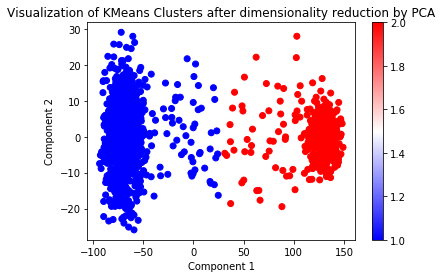

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)

pca.fit(df_u)
df_u_pca = pca.transform(df_u)

plt.figure()
plt.scatter(df_u_pca[:, 0], df_u_pca[:, 1], c=labels+1, cmap='bwr')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Visualization of KMeans Clusters after dimensionality reduction by PCA')
plt.colorbar();

## 10. Conclusions

A machine learning model has been developed to model the relationship between the input process conditions of a chemical reactor and the yield of the desired product. The machine learning model was trained on data generated from an analytical model of an example reactor, as real operating data was not available. 

The advantage of using a machine learning model to predict the yield over taking samples of the reactor products and calculating the yield directly is that it only requires enough sampling to establish a dataset suitable for a model to be trained on, and then the model can be put into use making real time predictions for the product yield, with no additional sampling or other equipment required.

A Random Forest machine learning model was developed, and it has been shown how the model can be used as part of a low yield "warning system" that can provide an alert when the reactor yield drops below a target value and then provide information on which process conditions are causing the decrease in yield, in an effort to help those involved with operating the reactor maintain maximum yield of the desired product. It was also shown how incorporating a threshold into the warning system to mitigate the error of the machine learning model results in improved performance of the warning system.

If no yield data is available, then it can be inferred by using unsupervised learning to assign labels to the data. The labels can then be qualitatively identified as high or low yield modes of operation based on knowledge of how the input process variables influence the yield of the chemical reactions. With a labelled dataset, it is then possible to develop a supervised learning classification model to make qualitative predictions for the yield, in contrast to the quantitative predictions that are possible if yield data is available.

## 11. Recommendations

In order to adapt the concepts presented in this project to a real world application, it is recommended to explore historical operational data related to the reactor of interest. If there is data available for the input process conditions to the reactor that has a strong relationship with the reactor yield, then a machine learning model could be developed. If no historical data for yield is available, then it would need to be collected. The value for yield does not necessarily need to be explicitly known, instead historical information for flowrates can be used to calculate the yield, like what has been performed in this project.

It is important to note that a machine learning model that predicts the yield has to be as accurate as taking samples of the reactor products, otherwise there is no advantage to be gained. Using a machine learning model to predict the yield within a "warning system" is likely most useful for reaction processes that experience larger changes in the input process conditions, rather than ones that are essentially always at steady state.

Unsupervised learning is a useful technique for inferring the reactor performance when yield data is not available, and in a real world application it would also be useful to attempt prior to supervised learning to help identify what operating modes are occuring.

## 12. References

[1] H. Scott Fogler, *Essentials of Chemical Reaction Engineering*, Prentice Hall, 2011.